# **Facets example**
This Jupyter script is an example for a use case of the Pyoskar API, which works in perfect combination with Pyspark in order to provide a genomic analysis tool. On this example we show some ways that could be of interest to start using the Facets functionality.

We have to go through this step before we start using Pyoskar:

In [7]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

## Simple Facet
Now that we have loaded our data, we start with an easy facet. This example executes the classics "groupBy" and "count" upon our dataframe basing on the variant types and the genes that contains them:

In [5]:
oskar.facet(df, "type").show()

+-----+-----+
| type|count|
+-----+-----+
|INDEL|  106|
|  SNV|  894|
+-----+-----+



In [8]:
oskar.facet(df, "gene").show(10)

+-----------+-----+
|       gene|count|
+-----------+-----+
|    ABCD1P4|    2|
|  ABHD17AP4|    2|
| AC000029.1|    1|
| AC000041.8|    2|
| AC000067.1|    1|
|AC000068.10|    1|
| AC000068.5|    1|
| AC000089.3|    1|
| AC002472.1|    4|
|AC004019.10|    1|
+-----------+-----+
only showing top 10 rows



## Include Facet
This next example goes a bit further and also applies a filtering based on the values we explicit in the function:

In [11]:
oskar.facet(df, "gene[BCL2L13,CECR2]").show()

+-------+-----+
|   gene|count|
+-------+-----+
|BCL2L13|    8|
|  CECR2|   11|
+-------+-----+



## Range facet
Using a similar sintax as with "Include facets" but dealing with quantitative fields instead of qualitative we find that we can apply facets by range, where we can determine both upper and downer thresholds as well as the step. Available range fields:
 - Conservation score: "grep", "phylop" & "phastCons"
 - Functional score: "cadd_scaled" & "cadd_raw"
 - Substitution score: "sift" & "polyphen"

In [108]:
oskar.facet(df, "phylop[-5..0]:1").show()

+-----------+-----+
|phylopRange|count|
+-----------+-----+
|       -4.0|    3|
|       -3.0|   12|
|       -2.0|   55|
|       -1.0|  171|
|        0.0|  681|
+-----------+-----+



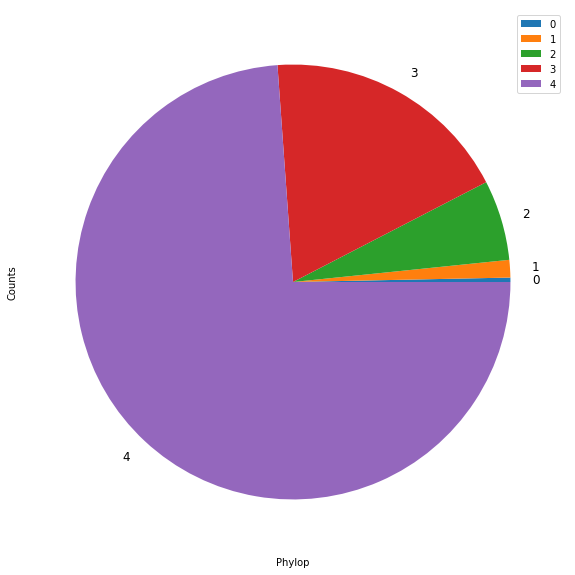

In [140]:
pandasDF = oskar.facet(df, "phylop[-5..0]:1").toPandas()
histogram = pandasDF.plot.pie(x = "phylopRange", y = "count", figsize=(24,10), fontsize=12).set(xlabel="Phylop", ylabel="Counts")

## Aggregation facet
We may want to check whether the compounds of all variants have historically been well conservated or otherways have notably evolved. For this task we could use the aggregation facets, with substitutes the default "count" function for another one we decide among this ones: average [avg], maximum [max], minimum [min], sumatory [sum], squared sumatory [sumsq], standard deviation [stddev], percentile values [percentile] or set of values [unique].

In [16]:
oskar.facet(df, "avg(gerp)").show(truncate=False)

+-------------------+-----+
|          avg(gerp)|count|
+-------------------+-----+
|-0.3518712293113349| 1000|
+-------------------+-----+



In [162]:
oskar.facet(df, "percentile(gerp)").show(truncate=False)

+---------------------------------------------------------------------------------------+-----+
|percentile(gerp)                                                                       |count|
+---------------------------------------------------------------------------------------+-----+
|[-2.152000093460083, -0.6257500052452087, 0.0, 0.14900000393390656, 0.7430999755859375]|1000 |
+---------------------------------------------------------------------------------------+-----+



In [170]:
# bw = oskar.facet(df, "percentile(gerp)").toPandas()
# bw.plot.box(x = "percentile(gerp)")

## Nested facets
The last feature we find available for our facet queries is nesting, which allows us to concatenate gruops and reach complex studies.

In [52]:
oskar.facet(df, "biotype>>ct[splice_donor_variant]").show(truncate=False)

+-----------------------+--------------------+-----+
|biotype                |ct                  |count|
+-----------------------+--------------------+-----+
|nonsense_mediated_decay|splice_donor_variant|1    |
|processed_transcript   |splice_donor_variant|1    |
|protein_coding         |splice_donor_variant|1    |
|retained_intron        |splice_donor_variant|1    |
+-----------------------+--------------------+-----+



## Final Facet
Now it is up to us to mix all these ingredients:

In [92]:
# STD DEV

In [91]:
oskar.facet(df, "gene[AIFM3,GGT1]>>biotype>>cadd_raw[-10..10]:0.2>>cadd_scaled[-10..10]:1>>min(phylop)").show(25, truncate=False)

+-----+-----------------------+-------------+----------------+--------------------+-----+
|gene |biotype                |cadd_rawRange|cadd_scaledRange|min(phylop)         |count|
+-----+-----------------------+-------------+----------------+--------------------+-----+
|AIFM3|lincRNA                |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|nonsense_mediated_decay|0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|processed_transcript   |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|protein_coding         |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|retained_intron        |0.2          |6.0             |-0.2809999883174896 |1    |
|GGT1 |nonsense_mediated_decay|-0.2         |0.0             |-1.1380000114440918 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |1.0             |0.10199999809265137 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |2.0             |0.054999999701976776|1    |
|GGT1 |non